In [49]:
#libraries for classfication
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression #Regression
from sklearn.linear_model import LinearRegression #Regression
from sklearn.metrics import mean_squared_error, r2_score #Regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score,StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
#for precision recall curve
from sklearn.metrics import precision_recall_curve, roc_curve,matthews_corrcoef
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize
from collections import Counter
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import paired_ttest_5x2cv
from scipy.stats import ttest_rel

PREVISUALIZACION DE LOS DATOS

In [50]:
def show_correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=True)
    plt.show()

In [51]:
#DATASET LOADING
#ESTE ES EL DATASET SIN MODIFICAR
df = pd.read_csv("B.HEALTH_classification.csv")

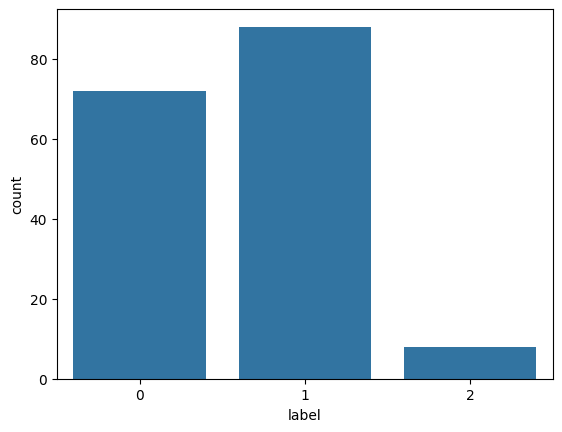

label
1    88
0    72
2     8
Name: count, dtype: int64
         subject         day    step count  distance travelled (km)  \
count  24.000000  168.000000    168.000000               168.000000   
mean   12.500000    4.000000   6225.803571                 4.492500   
std     7.071068    2.005979   4356.245120                 3.256826   
min     1.000000    1.000000    669.000000                 0.120000   
25%     6.750000    2.000000   2495.750000                 1.780000   
50%    12.500000    4.000000   5409.000000                 3.770000   
75%    18.250000    6.000000   9223.000000                 6.332500   
max    24.000000    7.000000  20134.000000                14.550000   

       calories burnt (kcal)  acive time (minutes)  \
count             168.000000            168.000000   
mean              500.619048             69.815476   
std               626.493385             45.475089   
min                18.000000             10.000000   
25%               115.750000      

In [52]:
#GRAFICA DEL DATASET
#GRAFICAMOS CANTIDAD DE DATOS POR CLASE
#0 es buena calidad 2 es mala calidad
sns.countplot(x='label', data=df)
plt.show()
print(df["label"].value_counts())
print(df.describe())

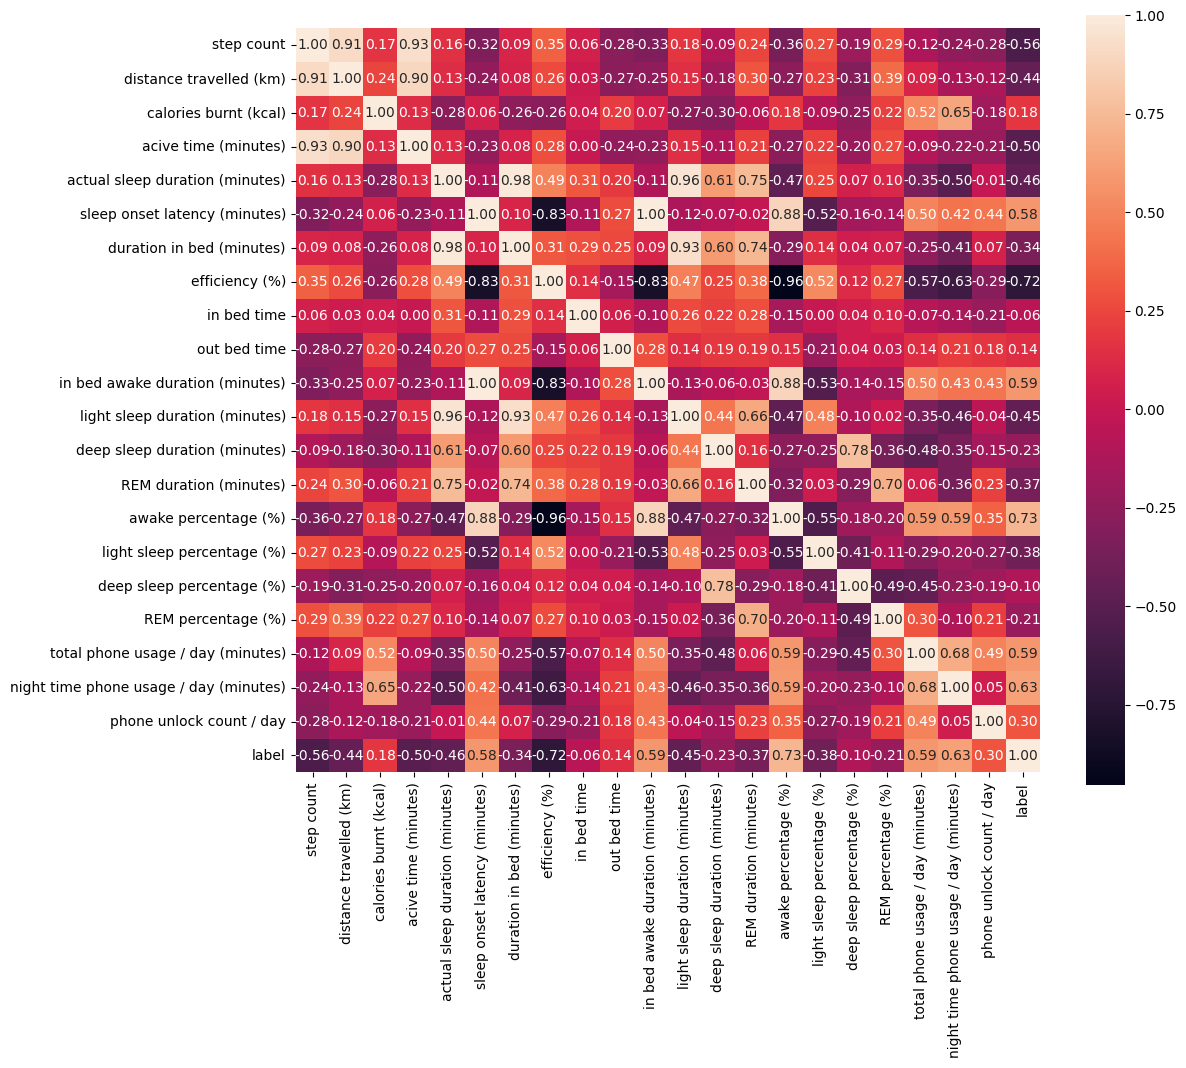

In [53]:
#MOSTRAR MATRIZ DE CORRELACION
base_df = df.drop(columns=["subject","day"])
columns = [] #si queremos ver la matriz de correlacion sin alguna columna agregarlo aqui
show_correlation_matrix(base_df.drop(columns=columns))

 PREPARACION DE LOS DATOS PARA EL ENTRENAMIENTO Y VISUALIZACION DE CARACTERISTICAS

In [54]:
def normalize_data(X, how="minmax"):
    if how == "minmax":
        scaler = MinMaxScaler()
    elif how == "standard":
        scaler = StandardScaler()
    return scaler.fit_transform(X)

In [55]:
def apply_tsne(X, n_components=2, pca=False):
    if pca:
        reduccion = TSNE(n_components, init='pca', random_state=40)
    else:
        reduccion = TSNE(n_components)
    x_new = reduccion.fit_transform(X)
    return x_new

In [56]:
def plot_data_TSNE(x,y): #plot with TSNE and PCA to reduce dimensions
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set(xlabel=" ", ylabel=" ")
    plt.tick_params(axis='both', which='major', labelsize=15)
    x_new = apply_tsne(x, n_components=2, pca=True)
    tmp_df = pd.DataFrame(np.column_stack([x_new, y]))
    tmp_df.columns = ["x1", "x2", "Y"]
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x="x1", y="x2", hue="Y", data=tmp_df, ax=ax)
    
    

In [57]:
#separate test and train data
def split_data(X, y, test_size=0.3):
    return train_test_split(X, y, test_size=test_size, random_state=1)

In [58]:
#REMOVEMOS COLUMNAS QUE NO QUEREMOS Y APLICAMOS SMOTE DE SER NECESARIO
remove_columns = ["subject","day", "label"] #remover columnas que no queremos para las variables
use_smote = True

X, Y = df.drop(columns=remove_columns), df["label"]

if use_smote:
    smote = SMOTE(sampling_strategy='minority')
    X, Y = smote.fit_resample(df.drop(columns=remove_columns), df["label"])


In [59]:
#NORMALIZAMOS LOS DATOS
X = normalize_data(X, how="minmax")

label
2    71
1    70
0    57
Name: count, dtype: int64


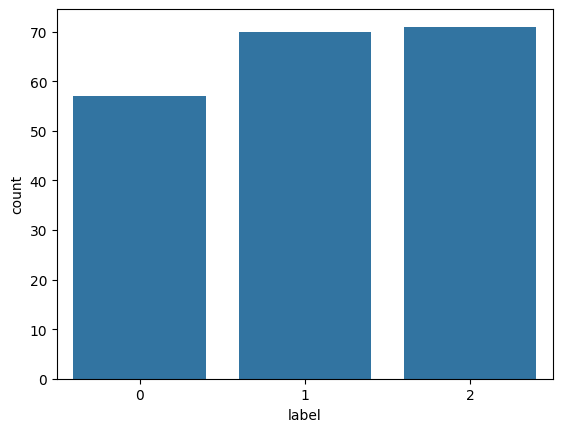

In [60]:
#SEPARAMOS LOS DATOS DE ENTRENAMIENTO Y PRUEBA
#SI NO ESTA USANDO SMOTE PROCURAR 50% DE LA
X_train, X_test, y_train, y_test = split_data(X, Y, test_size=0.2)
print(y_train.value_counts())
sns.countplot(x=y_train)
plt.show()

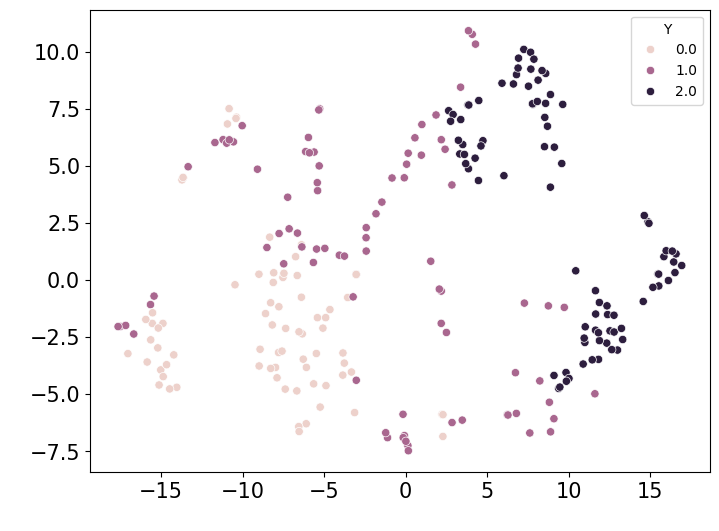

<Figure size 1200x600 with 0 Axes>

In [61]:
#PLOTTING DATA
plot_data_TSNE(X, Y)

ENTRENAMIENTO Y TUNNING DE MODELOS PARA CLASIFICACION

In [62]:
def select_model(model_name="DecisionTree"): 
    if model_name == "DecisionTree":
        return DecisionTreeClassifier()
    elif model_name == "SVM":
        return SVC()
    elif model_name == "RandomForest":
        return RandomForestClassifier()
    elif model_name == "XGBoost":
        return XGBClassifier()
    elif model_name == "MLP":
        return MLPClassifier()
    else:
        print("Invalid model name")
        return None

In [63]:
#comparing each model accuracy
def compare_models_accuracy(X_train, y_train, X_test, y_test):
    models = ["DecisionTree", "SVM", "RandomForest"]
    accuracies = []
    for model_name in models:
        model = select_model(model_name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return list(zip(models, accuracies))
        

In [64]:
def compare_models_accuracy(X_train, y_train, X_test, y_test):
    models = ["DecisionTree", "SVM", "RandomForest", "XGBoost"]
    accuracies = []
    for model_name in models:
        model = select_model(model_name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return list(zip(models, accuracies))

In [65]:
#plotting comparison of models with no hyperparameter tuning
comparison_list = compare_models_accuracy(X_train, y_train, X_test, y_test)
print(comparison_list)


[('DecisionTree', 0.86), ('SVM', 0.94), ('RandomForest', 0.94), ('XGBoost', 0.88)]


In [66]:
def parameter_tunning(model,parameters, method="grid", scoring_metric = "accuracy", cv = 5):
    if method == "grid":
        clf = GridSearchCV(model, param_grid=parameters, scoring=scoring_metric, cv=cv, n_jobs=-1)  
    # clf_svc = RandomizedSearchCV(clf_svc, param_distributions=parameters, scoring="accuracy", cv=5, n_jobs=-1, n_iter=15)
    else:
        clf = RandomizedSearchCV(model, param_distributions=parameters, scoring=scoring_metric, cv=cv, n_jobs=-1, n_iter=15)
    
    clf.fit(X_train, y_train)
    
    print("-----------------")
    print("Model", model.__class__.__name__)
    print("Best score : ", clf.best_score_)
    print("Best Parameters : ", clf.best_params_)
    print("-----------------")
    return clf

In [67]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    confusion = confusion_matrix(y_test, y_pred)
    print("Model", model.__class__.__name__)
    print("Accuracy: ", accuracy)
    print("F1 Score: ", f1)
    print("Confusion Matrix: ")
    print(confusion)
    return accuracy, f1, confusion

In [68]:
# parameters = {
#    "n_estimators":[i for i in range(1,200)],                   
#    "learning_rate":[0.1*i for i in range(1,10)],
#    "max_depth":[i for i in range(1,20)],                                            
# }
# useGridSearch = False
# parameter_tunning(select_model("XGBoost"), parameters, useGridSearch)

In [69]:
#DecisionTree parameters
# weights = np.linspace(0.0,0.99,20)
# print(weights)
# parameters = {
#     "criterion": ["gini", "entropy","log_loss"],
#     "max_depth": [i if i!=0 else None for i in range(1, 10)],
#     "max_features": ["auto", "sqrt", "log2"],
#     'class_weight': [{0:x, 1:1.0-x , 2:1.0 - x} for x in weights]
# }
# model = DecisionTreeClassifier()
# parameter_tunning(model, parameters, scoring_metric="f1_weighted")

In [70]:
# decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=9, max_features="sqrt")
# decision_tree.fit(X_train, y_train)
# y_pred = decision_tree.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy DecisionTree: ", accuracy)

In [71]:
# svm = SVC()
# #weights = np.linspace(0.0,0.99,200)
# parameters = {
#     "C": [0.1, 1, 10, 100],
#     "kernel": ["linear", "poly", "rbf", "sigmoid"], 
#     "gamma": [0.01*i for i in range(1, 100)],
#     #'class_weight': [{0:x, 1:1.0-x,2:1.0 - x} for x in weights]
# }
# parameter_tunning(svm, parameters,scoring_metric="f1_weighted")

In [72]:
# svm = SVC(C=10, degree=2, gamma=0.44, kernel="rbf")
# clf = svm.fit(X_train, y_train)
# y_pred = svm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy SVM: ", accuracy)

In [73]:

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in"""
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [74]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier."""
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [75]:
# random_f= RandomForestClassifier()

# parameters = {
#     "n_estimators": [50, 100, 200, 300],
#     "criterion": ["gini", "entropy","log_loss"],
#     "max_depth": [i if i!=0 else None for i in range(1, 10)],
#     "max_features": ["auto", "sqrt", "log2"],
#     'class_weight': [{0:x, 1:1.0-x , 2:1.0 - x} for x in weights]
# }
# parameter_tunning(random_f, parameters)

In [76]:
# random_f= RandomForestClassifier(criterion="entropy", max_depth=5, max_features="log2", n_estimators=50)
# random_f.fit(X_train, y_train)
# y_pred = random_f.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy RandomForest: ", accuracy)

In [77]:
# xgboost = XGBClassifier()
# parameters = {
#    "n_estimators":[i for i in range(1,200)],                   
#    "learning_rate":[0.1*i for i in range(1,10)],
#    "max_depth":[i for i in range(1,20)],
#    "max_features":[i for i in range(1,20)],
#    'class_weight': [{0:x, 1:1.0-x , 2:1.0 - x} for x in weights]
                                                  
# }
# parameter_tunning(xgboost, parameters, method="random", scoring_metric="f1_weighted")

In [78]:
# mlp_model = MLPClassifier()
# parameters = {
#     "hidden_layer_sizes": [(100,), (200,), (300,)],
#     "activation": ["identity", "logistic", "tanh", "relu"],
#     "solver": ["lbfgs", "sgd", "adam"],
#     "alpha": [0.0001, 0.001, 0.01, 0.1],
#     "learning_rate": ["constant", "invscaling", "adaptive"]
# }
# parameter_tunning(mlp_model, parameters)

In [79]:
# mlp_model = MLPClassifier(activation="relu", alpha=0.1, hidden_layer_sizes=(100,), learning_rate="invscaling", solver="adam")
# mlp_model.fit(X_train, y_train)
# y_pred = mlp_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy MLP: ", accuracy)

In [80]:
#LISTA DE MODELOS Y PARAMETROS PARA TUNEAR
models = [DecisionTreeClassifier(),SVC(),RandomForestClassifier(),XGBClassifier()]
weights = np.linspace(0.0,0.9,10) #lista de pesos para el entrenamiento con datos desbalanceados
parameters = [
    {
        "criterion": ["gini", "entropy","log_loss"],
        "max_depth": [i if i!=0 else None for i in range(0, 10)],
        "max_features": ["auto", "sqrt", "log2"],
        'class_weight': [{2:x} for x in weights]
    },
    {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"], 
        "gamma": [0.1*i for i in range(1, 100)],
        'class_weight': [{2:x} for x in weights]
    },
    {
        "n_estimators": [50, 100, 200, 300],
        "criterion": ["gini", "entropy","log_loss"],
        "max_depth": [i if i!=0 else None for i in range(0, 10)],
        "max_features": ["auto", "sqrt", "log2"],
        'class_weight': [{2:x} for x in weights]
    },
    {
        "n_estimators":[i for i in range(1,200)],                   
        "learning_rate":[0.1*i for i in range(1,10)],
        "max_depth":[i for i in range(1,20)],
        "max_features":[i for i in range(1,20)],
        'class_weight': [{2:x} for x in weights]
    },
]

#TUNEO DE HIPERPARAMETROS A CADA MODELO Y VALIDACION CRUZADA PARA CADA MODELO
#UTILIZAMOS TUNEO DE HIPERPARAMETROS CON VALIDACION CRUZADA PARA UN CRITERIO PRINCIPAL,
#DESPUES VERIFICAMOS EL MODELO CON CROSS VALI
best_models_with_scores = []
cv = StratifiedKFold(n_splits=5)
for i in range(len(models)):
    model = models[i]
    params = parameters[i]
    clf = parameter_tunning(model, params, method="random", scoring_metric="f1_weighted", cv=cv) #this shall return the best model with parameters

    best_models_with_scores.append((clf.best_estimator_, clf.best_score_, clf.best_params_))

best_models_with_scores    

c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\base.py", line 666, in _vali

-----------------
Model DecisionTreeClassifier
Best score :  0.8936281088042758
Best Parameters :  {'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'log_loss', 'class_weight': {2: np.float64(0.9)}}
-----------------
-----------------
Model SVC
Best score :  0.9178206231031819
Best Parameters :  {'kernel': 'poly', 'gamma': 2.5, 'class_weight': {2: np.float64(0.2)}, 'C': 10}
-----------------


c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\base.py", line 666, in _vali

-----------------
Model RandomForestClassifier
Best score :  0.9181131523371404
Best Parameters :  {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'log_loss', 'class_weight': {2: np.float64(0.1)}}
-----------------
-----------------
Model XGBClassifier
Best score :  0.8830405456612354
Best Parameters :  {'n_estimators': 77, 'max_features': 4, 'max_depth': 17, 'learning_rate': 0.1, 'class_weight': {2: np.float64(0.30000000000000004)}}
-----------------


c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


[(DecisionTreeClassifier(class_weight={2: np.float64(0.9)}, criterion='log_loss',
                         max_depth=9, max_features='sqrt'),
  np.float64(0.8936281088042758),
  {'max_features': 'sqrt',
   'max_depth': 9,
   'criterion': 'log_loss',
   'class_weight': {2: np.float64(0.9)}}),
 (SVC(C=10, class_weight={2: np.float64(0.2)}, gamma=2.5, kernel='poly'),
  np.float64(0.9178206231031819),
  {'kernel': 'poly',
   'gamma': 2.5,
   'class_weight': {2: np.float64(0.2)},
   'C': 10}),
 (RandomForestClassifier(class_weight={2: np.float64(0.1)}, criterion='log_loss',
                         max_depth=8, max_features='log2', n_estimators=50),
  np.float64(0.9181131523371404),
  {'n_estimators': 50,
   'max_features': 'log2',
   'max_depth': 8,
   'criterion': 'log_loss',
   'class_weight': {2: np.float64(0.1)}}),
 (XGBClassifier(base_score=None, booster=None, callbacks=None,
                class_weight={2: np.float64(0.30000000000000004)},
                colsample_bylevel=None, col

ANALISIS Y COMPARACION DE MODELOS


In [81]:
def decimal_to_time(decimal_time): ##calculo para pasar tiempo decimal a horas minutos y segundos
    """
    Convert a decimal time representation to HH:MM:SS format.
    
    Parameters:
    decimal_time (float): The decimal representation of time.
    
    Returns:
    str: The time in HH:MM:SS format.
    """
    total_seconds = int(decimal_time * 24 * 3600)
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"


print(decimal_to_time(0.457638889)) 
print(decimal_to_time(0.707638889)) 

10:59:00
16:59:00


In [82]:
def graph_precision_recall_curve(y_test, y_score, n_classes=3):
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

In [83]:
# #classifiers with best hyperparameters
if use_smote:
# #SMOTE
    decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, max_features="log2")
    xgbModel = XGBClassifier(learning_rate=0.2, max_depth=19, n_estimators=154)
    svm = SVC(C=100, degree=2, gamma=0.09, kernel="rbf",probability=True)
    random_f= RandomForestClassifier(criterion="entropy", max_depth=6, max_features="sqrt", n_estimators=50)
    # mlp_model = MLPClassifier(activation="relu", alpha=0.01, hidden_layer_sizes=(200,), learning_rate="invscaling", solver="adam")
else:
# # #WEIGHTED
    decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=None, max_features="sqrt",class_weight={2: np.float64(0.7)})
    xgbModel = XGBClassifier(learning_rate=0.4, max_depth=2,n_estimators=38)
    #xgbModel = XGBClassifier(learning_rate=0.4, max_depth=2, max_features=11, n_estimators=38,class_weight={2: np.float64(0.7)})
    svm = SVC(C=0.1, gamma=1, kernel="poly",probability=True,class_weight={2:0.9}) 
    random_f= RandomForestClassifier(criterion="log_loss", max_depth=7, max_features="sqrt", n_estimators=50 , class_weight= {2: np.float64(0.9)} )
    # mlp_model = MLPClassifier(activation="relu", alpha=0.01, hidden_layer_sizes=(200,), learning_rate="invscaling", solver="adam")
decision_tree.fit(X_train, y_train)
svm.fit(X_train, y_train)
random_f.fit(X_train, y_train)
xgbModel.fit(X_train, y_train)
# mlp_model.fit(X_train, y_train)
evaluate_model(decision_tree, X_test, y_test)
evaluate_model(svm, X_test, y_test)
evaluate_model(random_f, X_test, y_test)
evaluate_model(xgbModel, X_test, y_test)
# evaluate_model(mlp_model, X_test, y_test)

models = [decision_tree, svm, random_f, xgbModel]
#CROSS VALIDATION WITH TEST DATA
cross_val_scores = []
# cv = StratifiedKFold(n_splits=5)
cv = StratifiedKFold(n_splits=3)
for model in models:
    if use_smote:
        scores = cross_val_score(model, X_test, y_test, cv=cv, scoring="f1_macro")
    else:
        scores = cross_val_score(model, X_test, y_test, cv=cv, scoring="balanced_accuracy")
    cross_val_scores.append((model.__class__.__name__,scores.mean(), scores.std()))

print("Cross Validation Scores")
for model, mean, std in cross_val_scores:
    print(f"Model: {model}, Mean: {mean}, Std: {std}") 

Model DecisionTreeClassifier
Accuracy:  0.82
F1 Score:  0.8171038961038961
Confusion Matrix: 
[[12  3  0]
 [ 5 12  1]
 [ 0  0 17]]
Model SVC
Accuracy:  0.94
F1 Score:  0.9397763280521901
Confusion Matrix: 
[[13  2  0]
 [ 1 17  0]
 [ 0  0 17]]
Model RandomForestClassifier
Accuracy:  0.94
F1 Score:  0.938974358974359
Confusion Matrix: 
[[12  3  0]
 [ 0 18  0]
 [ 0  0 17]]
Model XGBClassifier
Accuracy:  0.86
F1 Score:  0.8545365853658536
Confusion Matrix: 
[[ 9  6  0]
 [ 1 17  0]
 [ 0  0 17]]


c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\s

Cross Validation Scores
Model: DecisionTreeClassifier, Mean: nan, Std: nan
Model: SVC, Mean: nan, Std: nan
Model: RandomForestClassifier, Mean: nan, Std: nan
Model: XGBClassifier, Mean: nan, Std: nan


c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oscar\Desktop\FinalMachineLearning\.venv\Lib\site-packages\s

In [84]:
#WEIGHING CLASSES
# svm = SVC(probability=True)

# weights = np.linspace(0.0,0.99,200)
# param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
# #Fitting grid search to the train data with 5 folds
# gridsearch_csv_results = parameter_tunning(svm, param_grid, method="grid")

# #Ploting the score for different values of weight
# sns.set_style('whitegrid')
# plt.figure(figsize=(12,8))
# weigh_data = pd.DataFrame({ 'score': gridsearch_csv_results['mean_test_score'], 'weight': (1- weights)})
# sns.lineplot(data=weigh_data, y='score', x='weight')
# plt.xlabel('Weight for class 1')
# plt.ylabel('F1 score')
# plt.xticks([round(i/10,1) for i in range(0,11,1)])
# plt.title('Scoring for different class weights', fontsize=24)

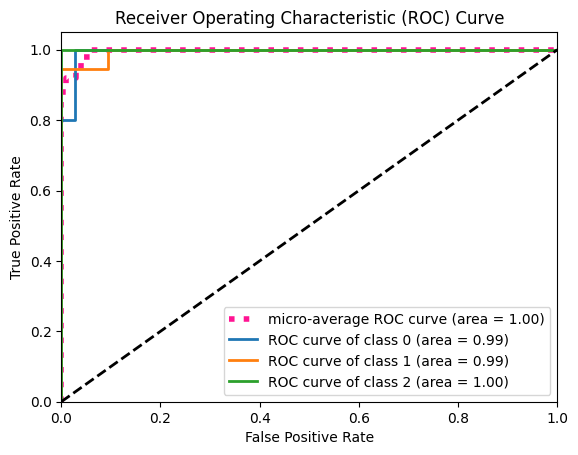

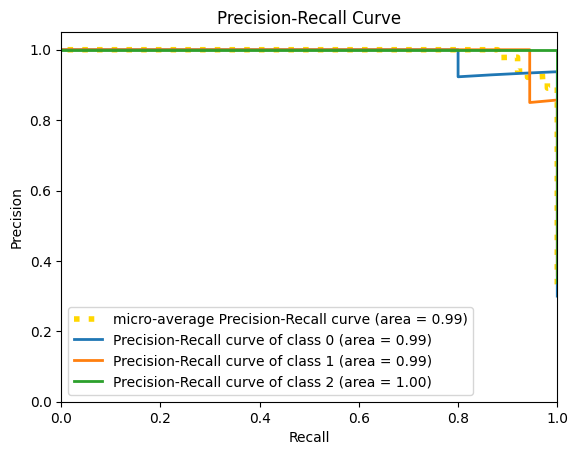

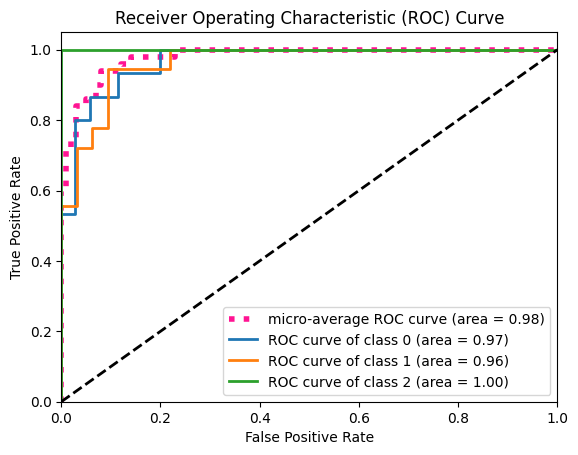

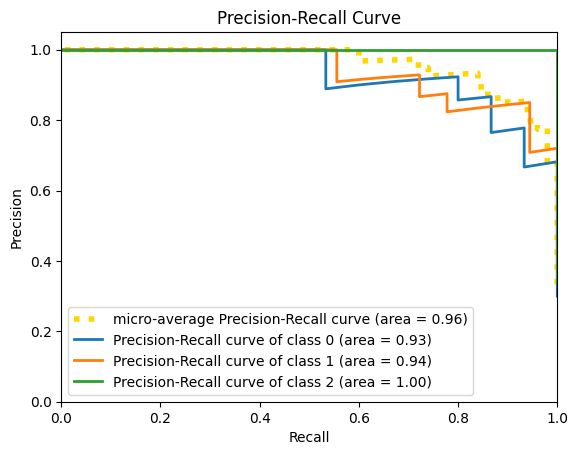

In [85]:
#Testing model with best hyperparameters and weights or smote
# model = SVC(C=100, gamma=0.03, kernel="rbf",probability=True,class_weight={0: 0.5223618090452261, 1:0.4776381909547739, 2:0.4776381909547739}) #model without smote and applying weights
# #model = SVC(C=100, degree=2, gamma=0.09, kernel="rbf",probability=True) #model with smote
# evaluate_model(model,X_test, y_test)

# n_classes = 3
# Y_pr = label_binarize(Y, classes=[0, 1, 2])#esto es necesario para la curva de precision recall
# for model in best_models_with_scores:
#     y_score = model[0].predict_proba(X_test)
#     graph_precision_recall_curve(y_test, y_score, n_classes)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


def plot_roc_and_pr_curves(y_test, y_score, classes):
    n_classes = y_test.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Compute Precision-Recall curve and average precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

    # Compute micro-average Precision-Recall curve and average precision
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall["micro"], precision["micro"],
             label='micro-average Precision-Recall curve (area = {0:0.2f})'
                   ''.format(average_precision["micro"]),
             color='gold', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2,
                 label='Precision-Recall curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Example usage:
# Assuming y_test and y_score are your test labels and predicted scores respectively
# and classes is a list of class names or labels

model1 = svm
model2 = xgbModel

y_score = model1.predict_proba(X_test)
Y_test_binarize = label_binarize(y_test, classes=[0, 1, 2])
classes = [0, 1, 2]
plot_roc_and_pr_curves(Y_test_binarize, y_score, classes)

y_score = model2.predict_proba(X_test)
Y_test_binarize = label_binarize(y_test, classes=[0, 1, 2])
classes = [0, 1, 2]
plot_roc_and_pr_curves(Y_test_binarize, y_score, classes)


In [86]:
def mcnemar_test_between_models(models, X_test, y_test, alpha=0.05):
    n_models = len(models)
    wins = np.zeros(n_models)
    
    # Convert y_test to a numpy array
    y_test = np.array(y_test)
    
    # Get predictions for each model
    predictions = [model.predict(X_test) for model in models]
    
    # Perform pairwise McNemar tests
    for i in range(n_models):
        for j in range(i + 1, n_models):
            # Create contingency table
            contingency_table = np.zeros((2, 2))
            for k in range(len(y_test)):
                if predictions[i][k] == y_test[k] and predictions[j][k] == y_test[k]:
                    contingency_table[0, 0] += 1
                elif predictions[i][k] == y_test[k] and predictions[j][k] != y_test[k]:
                    contingency_table[0, 1] += 1
                elif predictions[i][k] != y_test[k] and predictions[j][k] == y_test[k]:
                    contingency_table[1, 0] += 1
                else:
                    contingency_table[1, 1] += 1
            
            # Perform McNemar test
            result = mcnemar(contingency_table, exact=True)
            p_value = result.pvalue
            
            # Print contingency table and p-value
            print(f"Comparison between model {i} and model {j}:")
            print("Contingency table:")
            print(contingency_table)
            print(f"P-value: {p_value}\n")
            
            # Update wins based on p-value
            if p_value < alpha:
                if contingency_table[0, 1] > contingency_table[1, 0]:
                    wins[i] += 1
                else:
                    wins[j] += 1
    
    # Determine the best model
    best_model_index = np.argmax(wins)
    best_model = models[best_model_index]
    
    return best_model, wins

# Example usage:
# Assuming you have trained models: model1, model2, model3
# and you have test data: X_test, y_test

models = [xgbModel, decision_tree, random_f, svm]
best_model, wins = mcnemar_test_between_models(models, X_test, y_test, alpha=0.05)

print("Best model:", best_model)
print("Wins:", wins)

Comparison between model 0 and model 1:
Contingency table:
[[35.  8.]
 [ 6.  1.]]
P-value: 0.79052734375

Comparison between model 0 and model 2:
Contingency table:
[[42.  1.]
 [ 5.  2.]]
P-value: 0.21875

Comparison between model 0 and model 3:
Contingency table:
[[42.  1.]
 [ 5.  2.]]
P-value: 0.21875

Comparison between model 1 and model 2:
Contingency table:
[[40.  1.]
 [ 7.  2.]]
P-value: 0.0703125

Comparison between model 1 and model 3:
Contingency table:
[[40.  1.]
 [ 7.  2.]]
P-value: 0.0703125

Comparison between model 2 and model 3:
Contingency table:
[[46.  1.]
 [ 1.  2.]]
P-value: 1.0

Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=

In [87]:
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import paired_ttest_5x2cv
def apply_mcnemar_test(real, pred_A, pred_B):
    """
    Apply the McNemar test given the real values and predictions from two models.
    
    Parameters:
    real (array-like): True labels.
    pred_A (array-like): Predictions from model A.
    pred_B (array-like): Predictions from model B.
    
    Returns:
    result: The result of the McNemar test.
    """
    # Compute confusion matrices
    cm_A = confusion_matrix(real, pred_A)
    cm_B = confusion_matrix(real, pred_B)

    # Construct the contingency table
    b = np.sum((pred_A == real) & (pred_B != real))
    c = np.sum((pred_A != real) & (pred_B == real))
    

    contingency_table = np.array([[0, b], [c, 0]])

    print("Contingency Table:")
    print(contingency_table)

    # Apply the McNemar test
    result = mcnemar(contingency_table, exact=True)

    print(f"McNemar test statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")

    if result.pvalue < 0.05:
        print("There is a significant difference between the classifiers.")
    else:
        print("There is no significant difference between the classifiers.")
    
    return result

In [88]:
print(apply_mcnemar_test(y_test, svm.predict(X_test), random_f.predict(X_test)))

Contingency Table:
[[0 1]
 [1 0]]
McNemar test statistic: 1.0
p-value: 1.0
There is no significant difference between the classifiers.
pvalue      1.0
statistic   1.0


In [89]:
print(paired_ttest_5x2cv(estimator1=random_f, estimator2=svm, X=X, y=Y, scoring='f1_weighted', random_seed=1))

(0.016948897597276455, 0.9871329094187096)


In [90]:
matthews_corrcoef(y_test, xgbModel.predict(X_test))


np.float64(0.7998733490336761)

In [91]:
matthews_corrcoef(y_test, svm.predict(X_test))

np.float64(0.9704491450613604)

In [92]:
matthews_corrcoef(y_test, random_f.predict(X_test))

np.float64(0.9704491450613604)

In [93]:
matthews_corrcoef(y_test, decision_tree.predict(X_test))

np.float64(0.733453670276775)

In [94]:
from confidenceinterval import f1_score as f1_score_ci,accuracy_score as accuracy_score_ci

def calculate_confidence_interval(y_true, y_pred, confidence=0.95):
    if use_smote:
        model_acc, ci = accuracy_score_ci(y_true, y_pred, confidence=confidence, average="macro")
    else:
        model_acc, ci = f1_score_ci(y_true, y_pred, confidence=confidence, average="macro")
    return model_acc, ci

model_to_test = xgbModel
confidence_percentage = 0.95

value, interval = calculate_confidence_interval(y_test, model_to_test.predict(X_test), confidence=confidence_percentage)
print(f"Accuracy/f1_score at {confidence_percentage} % : {value} with confidence interval: {interval}") 

y_proba = model_to_test.predict_proba(X_test)
y_test = model_to_test.predict(X_test)
confidence_levels = np.max(y_proba, axis=1)
print(confidence_levels[:10])  # Print confidence for the first 10 predictions

Accuracy/f1_score at 0.95 % : 0.86 with confidence interval: (0.7381380628941446, 0.9304916657298371)
[0.99912816 0.996707   0.99597615 0.99748945 0.93785214 0.9964671
 0.9967681  0.9966427  0.9959566  0.9951879 ]


In [95]:
# from sklearn.utils import resample
# from sklearn.metrics import accuracy_score

# n_iterations = 1000
# scores = []

# model = xgbModel
# for i in range(n_iterations):
#     # Resample the dataset
#     X_resample, y_resample = resample(X_train, y_train)
#     model.fit(X_resample, y_resample)
#     y_pred = model.predict(X_test)
#     scores.append(accuracy_score(y_test, y_pred))

# # Compute confidence intervals
# alpha = 0.95
# lower = np.percentile(scores, (1 - alpha) / 2 * 100)
# upper = np.percentile(scores, (1 + alpha) / 2 * 100)

# print(f"{alpha*100}% confidence interval for accuracy: [{lower:.3f}, {upper:.3f}]")


In [96]:
# #APPLYTING TSNE TO VISUALIZE DATA WITH SVC
# plot_data_TSNE(X, Y)
# plt.show()
# X_tsne = apply_tsne(X, n_components=2, pca=True)
# X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = split_data(X_tsne, Y)
# clf = svm.fit(X_train_tsne, y_train_tsne)

#  # Create a meshgrid for plotting
# X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
# xx, yy = make_meshgrid(X0, X1)

# # Plot the decision boundaries
# fig, ax = plt.subplots()
# plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
# ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_title('SVM Decision Boundary')
# plt.show()
